## Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# !pip install wandb
import wandb
from google.colab import userdata

wandb.login(key=userdata.get("WANDB_KEY"))

wandb: Currently logged in as: kukubaczek (qqb). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Prepare data

In [ ]:
batch_size = 16

# transform data to reduce overfitting
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(
            size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1), antialias=True
        ),
        transforms.Normalize(0, 1),
    ]
)

# train and test data
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# labels
data_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


## Split into patches

In [ ]:
# [N, C, *]
def split_into_patches(images, patch_size=8, patch_stride=8):
    patches = images.unfold(2, patch_size, patch_stride).unfold(
        3, patch_size, patch_stride
    )
    patches = patches.contiguous().view(
        patches.size(0), patches.size(1), -1, patches.size(4), patches.size(5)
    )
    return patches.permute(0, 2, 1, 3, 4)


x, l = next(iter(trainloader))
print(x.shape, l)
splitted = split_into_patches(x)
print(splitted.shape)

torch.Size([16, 3, 32, 32]) tensor([0, 4, 5, 9, 9, 5, 2, 8, 8, 9, 0, 0, 8, 7, 2, 7])
torch.Size([16, 16, 3, 8, 8])


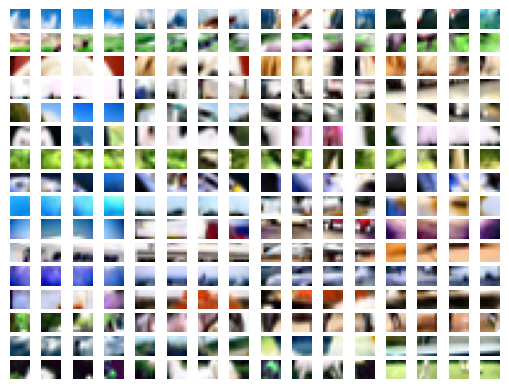

In [ ]:
patches = split_into_patches(x)

N, P, C, Hf, Wf = patches.shape

fig, axs = plt.subplots(N, P)

for i in range(N):
    for j in range(P):
        img = (
            patches[i, j].permute(1, 2, 0).detach().numpy()
        )  # Change from [C, H, W] to [H, W, C] and convert to numpy array
        img = (img - img.min()) / (
            img.max() - img.min()
        )  # Normalize to [0, 1] for displaying
        axs[i, j].imshow(img)
        axs[i, j].axis("off")  # To not display axes

plt.show()

## Model definition

![ViT model](vit.png)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, patch_size=4, embeddings=256):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm([65, embeddings])
        self.mha = nn.MultiheadAttention(embed_dim=256, num_heads=8, batch_first=True)

        self.layer_norm_2 = nn.LayerNorm([65, embeddings])
        self.linear_1 = nn.Linear(256, 512)
        self.gelu = nn.GELU()
        self.dropout_1 = nn.Dropout(0.2)
        self.linear_2 = nn.Linear(512, 256)
        self.dropout_2 = nn.Dropout(0.2)

    def forward(self, x):
        # IN: (N, 256)
        residual1 = x

        x = self.layer_norm_1(x)

        # self attention
        x, _ = self.mha(x, x, x)

        residual2 = torch.add(x, residual1)

        x = self.layer_norm_2(residual2)

        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.dropout_2(x)

        x = torch.add(x, residual2)

        # OUT: (N, 256)
        return x

In [ ]:
class VisualTransformer(nn.Module):
    def __init__(self, patch_size=4, embeddings=256, transformers_amount=6):
        super().__init__()
        self.patch_size = patch_size

        self.projection = nn.Sequential(
            nn.Flatten(-3, -1),
            # C x Hp x Wp
            nn.Linear(3 * 4 * 4, embeddings),
        )

        self.positional_embedding = nn.Embedding(256, 256)

        self.class_token = nn.Parameter(torch.zeros(embeddings).to(device))
        self.dropout = nn.Dropout(0.2)

        self.transformers = nn.ModuleList(
            [Transformer() for _ in range(transformers_amount)]
        )

        self.layer_norm = nn.LayerNorm([256])
        self.linear = nn.Linear(256, 10)

    def forward(self, images):
        patches = split_into_patches(images, 4, 4)

        projected_patches = self.projection(patches)

        positions = torch.arange(64 + 1).to(device)
        class_token = torch.unsqueeze(self.class_token, 0).expand(len(images), -1, -1)

        linear_embeddings = self.positional_embedding(positions).expand(
            len(images), -1, -1
        )

        embedding = (
            torch.cat([class_token, projected_patches], dim=1) + linear_embeddings
        )

        x = self.dropout(embedding)

        for transformer in self.transformers:
            x = transformer(x)

        only_class_token = x[:, 0, :]

        x = self.layer_norm(only_class_token)

        x = self.linear(x)

        return x

## Training

  0%|          | 0/160 [00:00<?, ?it/s]

Finished 0 epoch with loss 1.914397, accuracy: 0.348300
Finished 1 epoch with loss 1.675609, accuracy: 0.423200
Finished 2 epoch with loss 1.553920, accuracy: 0.463400
Finished 3 epoch with loss 1.483149, accuracy: 0.488900
Finished 4 epoch with loss 1.419434, accuracy: 0.492800
Finished 5 epoch with loss 1.369976, accuracy: 0.516700
Finished 6 epoch with loss 1.323342, accuracy: 0.530000
Finished 7 epoch with loss 1.285588, accuracy: 0.533600
Finished 8 epoch with loss 1.251843, accuracy: 0.541800
Finished 9 epoch with loss 1.215733, accuracy: 0.559400
Finished 10 epoch with loss 1.188976, accuracy: 0.563400
Finished 11 epoch with loss 1.160571, accuracy: 0.566000
Finished 12 epoch with loss 1.136839, accuracy: 0.575300
Finished 13 epoch with loss 1.107391, accuracy: 0.574600
Finished 14 epoch with loss 1.089583, accuracy: 0.577100
Finished 15 epoch with loss 1.062289, accuracy: 0.586800
Finished 16 epoch with loss 1.039559, accuracy: 0.595700
Finished 17 epoch with loss 1.023657, acc

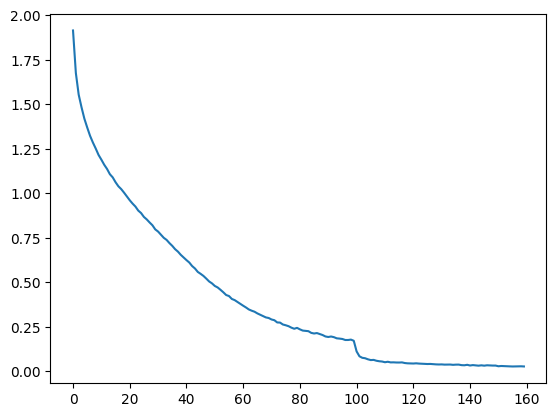

In [ ]:
LR = 0.0001
EPOCHS = 160

run = wandb.init(
    project="mro-transformers",
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)


def train(data, data_test, batch_size=64, epochs=EPOCHS, T=1000):
    model = VisualTransformer().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

    loss_history = []

    torch.set_grad_enabled(True)
    model.train()

    for epoch in trange(epochs):
        total_loss = 0

        # train
        for batch, labels in data:
            batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model(batch)

            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(data)

        # validate
        correct = 0
        total = 0
        for batch, labels in data_test:
            batch, labels = batch.to(device), labels.to(device)
            output = model(batch)
            predicted_labels = torch.argmax(output, dim=1)

            total += len(batch)
            correct += sum(predicted_labels == labels)

        # store data
        wandb.log({"avg_loss": avg_loss, "accuracy": correct / total})
        print(
            f"Finished {epoch} epoch with loss {avg_loss:2f}, accuracy: {correct / total :2f}"
        )

        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_snapshot_{epoch}.pt")
        loss_history.append(avg_loss)

    plt.plot(loss_history)

    return model


trained_model = train(trainloader, testloader)

## Results

In [ ]:
def analyze_images(images, labels, start=0):
    # move images and labels to the selected device
    images, labels = images.to(device), labels.to(device)

    # make a prediction
    outputs = trained_model(images)
    _, predicted = torch.max(outputs, 1)

    # dispay predicted images with labels
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    for i, (image, label, prediction) in enumerate(
        list(zip(images, labels, predicted))[start:]
    ):
        if i > 3:
            break
        img = image.permute(1, 2, 0).detach().cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(
            f"Pred / Correct: {data_labels[prediction.item()]:<10} / {data_labels[label.item()]:<10}",
            fontsize=10,
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

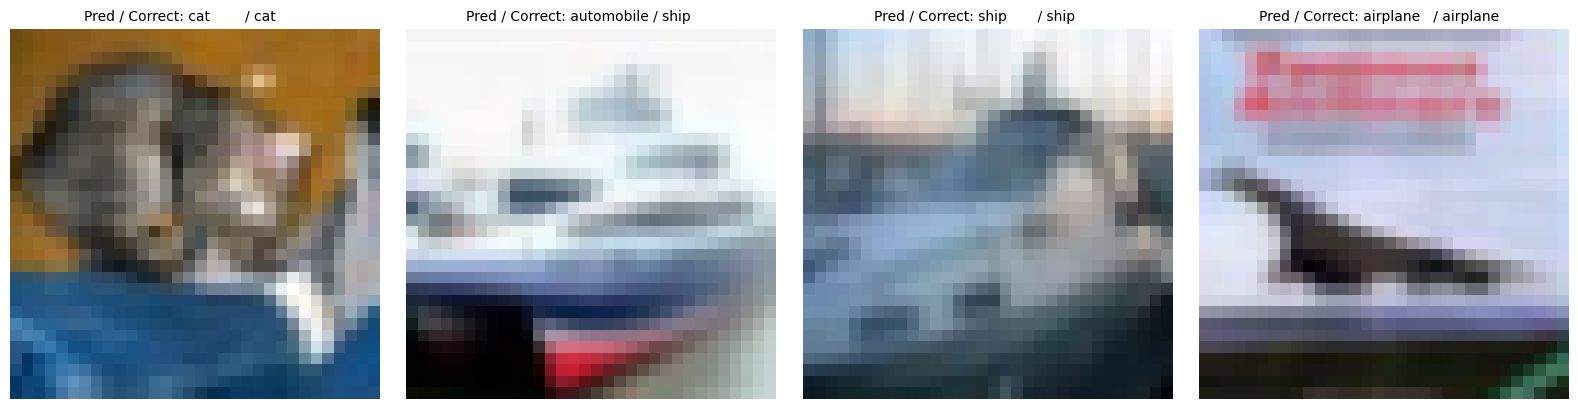

In [ ]:
analyze_images(*next(iter(testloader)))

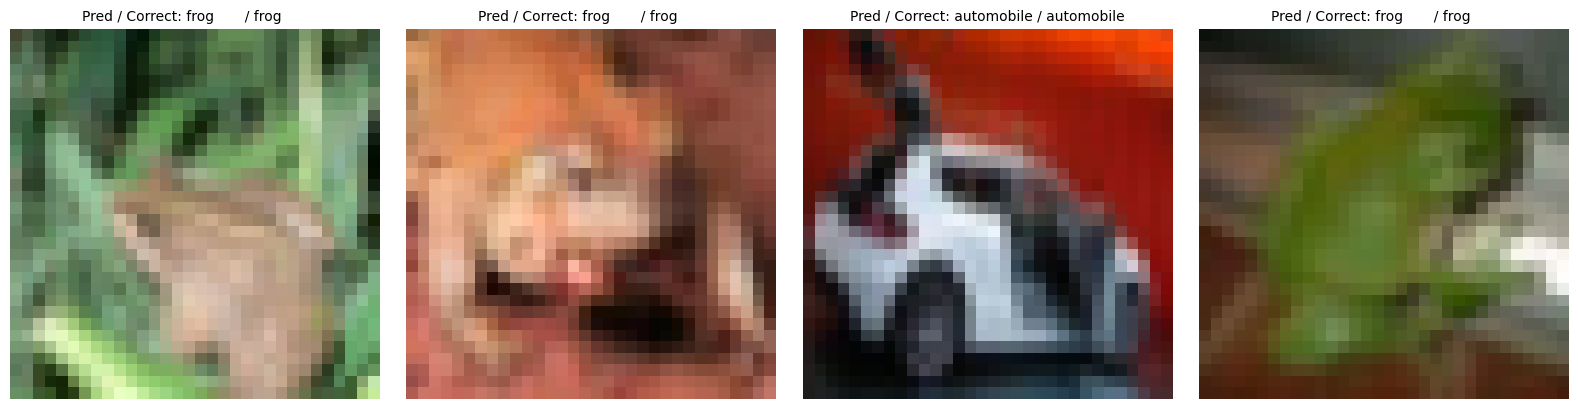

In [ ]:
analyze_images(*next(iter(testloader)), 4)

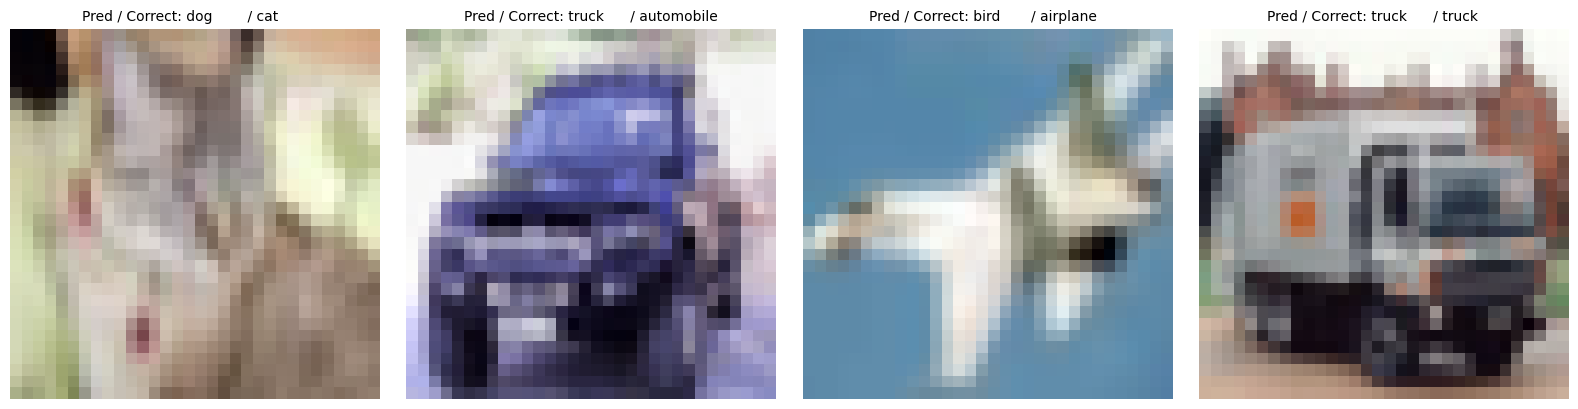

In [ ]:
analyze_images(*next(iter(testloader)), 8)

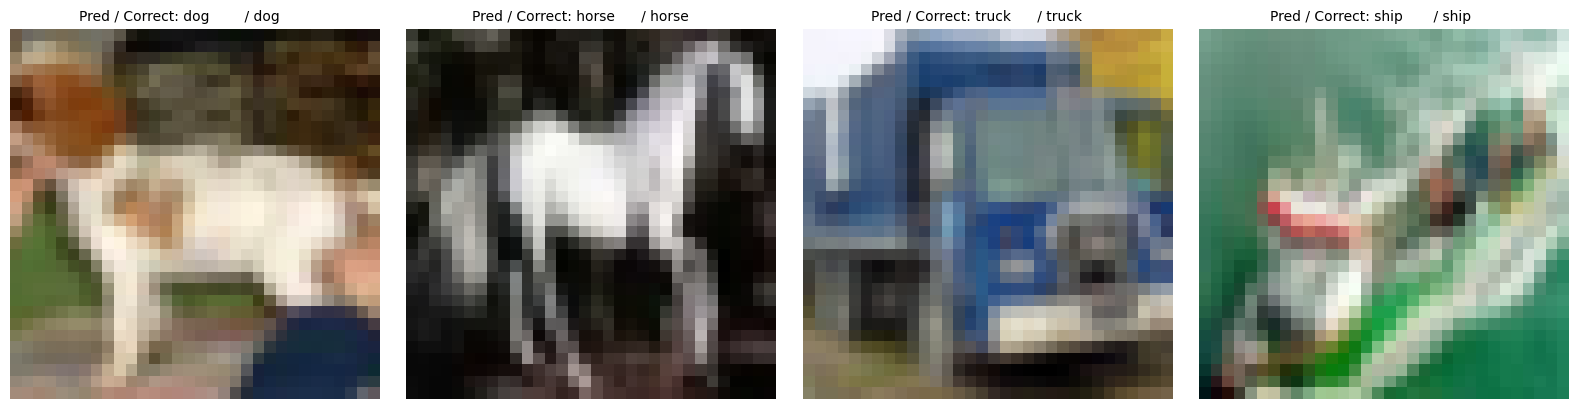

In [ ]:
analyze_images(*next(iter(testloader)), 12)

## Conclusions
- accuracy stopped increasing after about ~100 epochs,
- pretty good results, about 67% accuracy.